In [5]:
# All code from: http://www.wildml.com/2015/09/implementing-a-neural-network-from-scratch/
# Most comments by Kai Heinrich
# Package imports
import matplotlib.pyplot as plt # We need this to plot stuff
import numpy as np #We need this to handle all sorts of numerical vector computation
import sklearn # We need this for machine learning functions
import sklearn.datasets # We need this for generating our dataset
import sklearn.linear_model # We need this for the demonstration of a logistic regression before we develop an ANN
import matplotlib # We need this for plotting stuff as well

# Display plots inline and change default figure size
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

In [6]:
X,y=sklearn.datasets.make_moons(200,noise=0.20) 
#the make_moons function returns a matrix of x1 and x2 values (=X) and a label vector (=Y from {0,1})
# it uses following parameter:
    #number of points (x1,x2), n=200
    #sd of gaussian noiseadded to the data, noise=0.2
#for more reference see: http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html

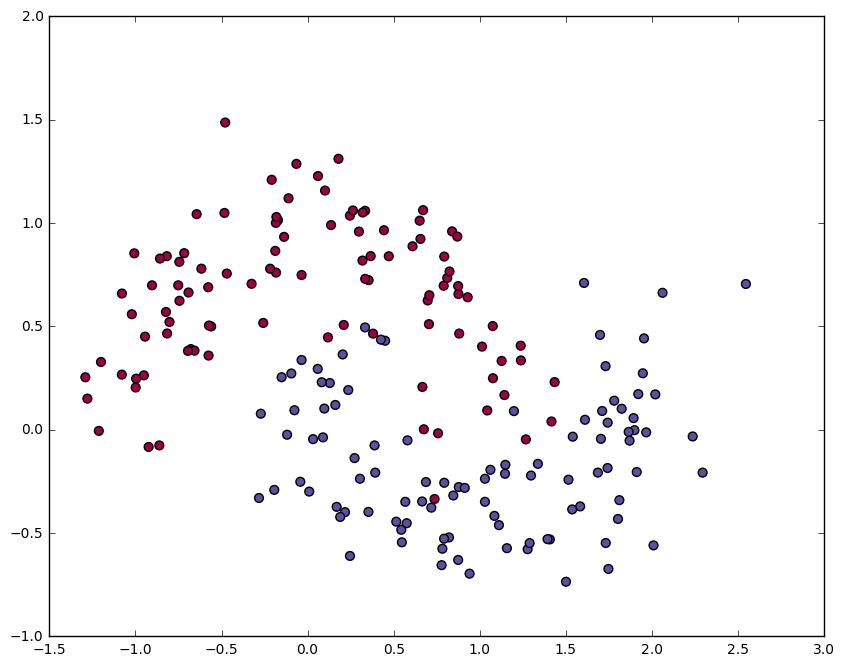

In [7]:
plt.scatter(X[:,0], X[:,1], s=40, c=y, cmap=plt.cm.Spectral)
#this plots the data, first two arguments are the x and y coordinates of the data
    #x=x1=first column of X=X[:,0] 
    #y=x2=second column of X=X[:,1]
#s is the point size in pts scale, in this case s=40
#c indicates the source column of the different colors
    #since we want the two clases to be colored differently we choose our y vector here, c=y
#cmap: you can set a colormap here where the colors should be choosen from
    #for reference see: http://matplotlib.org/examples/color/colormaps_reference.html
#for general pyplot reference see: http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.scatter

In [8]:
# Train the logistic rgeression classifier
clf = sklearn.linear_model.LogisticRegressionCV()
clf.fit(X, y)
#we use a ready-made function here to fit a logistic regression:
    #all we have to do is select the model and save it to the variable clf
    #from the sklearn.linear_model library we choose logistic regression
#we then just fit the model to our dataset
    #the model has a fit method which only needs the data: our matrix X for our features and our matrix y for the target
    #For reference see: http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [9]:
# Helper function to plot a decision boundary.
# If you don't fully understand this function don't worry, it just generates the contour plot below.
#Idea: 
#(1)We build a coordinate system taht is within the range of our data
#(2) We put a lot of points (xx,yy) in a grid there, so that the points have small distance from each other
    #Idea here: points are close together the contour will just translatte into an area full of ONE colour for each label
#(3) We use a previously defined model to predict the label of the points -->Z (this is the function argument pred_func)
#(4) We use xx, yy and their labels Z to make a contour plot 
    #(does not color the points but the areas around them in the color based on Z)
#(5) We put the scatter plot from before on top of it
def plot_decision_boundary(pred_func):
    # Set min and max values depending on data matrix and give it some padding-->(1)
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them, that will be the points we put the contour on-->(2)
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid, that gives the contour the color-->(3)
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)# makes contour plots of z, surface is xx and yy-->(4)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)#plots the normal scatter plot -->(5)
    #for contourplot reference see http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.contourf

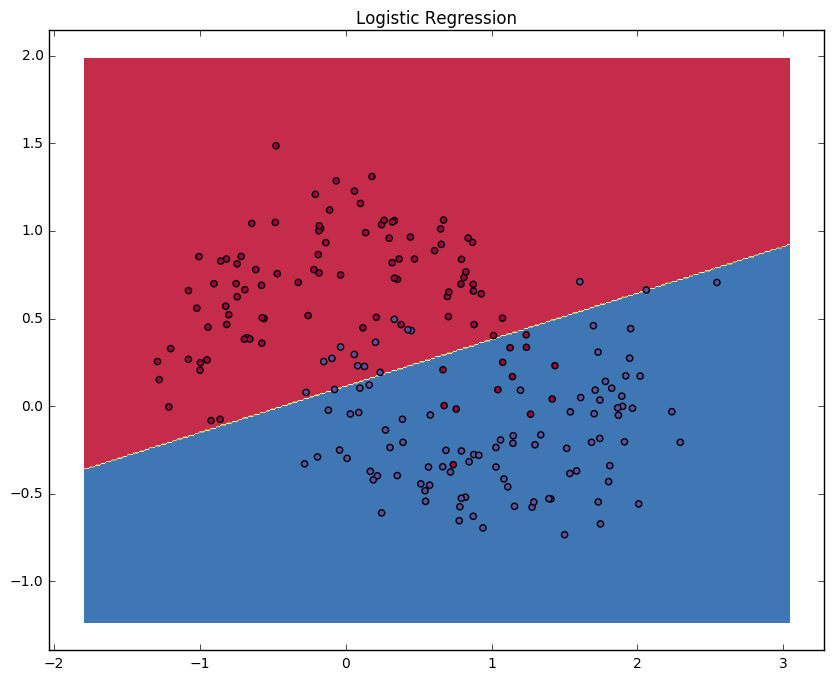

In [10]:
# Plot the decision boundary
#We use the function from before and use our model's (=clf) predict method clf.predict() as argument to create Z
    #the predict() method like the fit() method before comes with the predict object from sklearn   
plot_decision_boundary(clf.predict) 
plt.title("Logistic Regression")#sets title for plot

In [17]:
#Defining some parameters taht makes it easier to work with the optimization algorithm called gradient descent
#Network achitecture
num_examples = len(X) # training set size
nn_input_dim = 2 # input layer dimensionality
nn_output_dim = 2 # output layer dimensionality

# Gradient descent parameters (I picked these by hand)
epsilon = 0.01 # learning rate for gradient descent
reg_lambda = 0.01 # regularization strength

In [18]:
#We now define the loss function (the function we wish to minimize with gradient descent)
# Helper function to evaluate the total loss on the dataset
def calculate_loss(model):
    #weights W and bias b for the layers (W1--> from input to hidden, W2 from hidden to output, b1,b2 respectively)
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    # Forward propagation to calculate our predictions
    z1 = X.dot(W1) + b1 #calculate values of hidden layers
    a1 = np.tanh(z1) #apply activation function to HL value
    z2 = a1.dot(W2) + b2 #calculate output values
    # calculating the activation of the output layer with softmax function:-->2-dim vector for 2 output neurons
    exp_scores = np.exp(z2) #numerator of softmax (unnormalized log probabilites)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) #softmax class probabilities for both output neurons
    # Calculating the loss
    corect_logprobs = -np.log(probs[range(num_examples), y]) #vector of cross entropy losses for eacht data point
    data_loss = np.sum(corect_logprobs) #total loss summed up from the vector above
    # Add regulatization term to loss (optional)
    data_loss += reg_lambda/2 * (np.sum(np.square(W1)) + np.sum(np.square(W2)))
    return 1./num_examples * data_loss

In [19]:
# Helper function to predict an output (0 or 1)
#Function does:
    #forward propagation based on weights and an input x 
    #calculates softmax vector like 
    #assigns a class based on the highest prob in the softmax vector and returns that value
    #besides the last line of code this the same as the beginning of calculate_loss 
def predict(model, x):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    # Forward propagation
    z1 = x.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    return np.argmax(probs, axis=1)# returns max of prob vector and puts out a single class value for x

We want to implement the backpropagation with gradient descent now, remember the formulas for backpropagation
<img src="http://s0.wp.com/latex.php?zoom=1.25&latex=%5Cbegin%7Baligned%7D++%26+%5Cdelta_3+%3D+%5Chat%7By%7D+-+y+%5C%5C++%26+%5Cdelta_2+%3D+%281+-+%5Ctanh%5E2+z_1%29+%5Ccirc+%5Cdelta_3W_2%5ET+%5C%5C++%26+%5Cfrac%7B%5Cpartial%7BL%7D%7D%7B%5Cpartial%7BW_2%7D%7D+%3D+a_1%5ET+%5Cdelta_3+%5C%5C++%26+%5Cfrac%7B%5Cpartial%7BL%7D%7D%7B%5Cpartial%7Bb_2%7D%7D+%3D+%5Cdelta_3%5C%5C++%26+%5Cfrac%7B%5Cpartial%7BL%7D%7D%7B%5Cpartial%7BW_1%7D%7D+%3D+x%5ET+%5Cdelta2%5C%5C++%26+%5Cfrac%7B%5Cpartial%7BL%7D%7D%7B%5Cpartial%7Bb_1%7D%7D+%3D+%5Cdelta2+%5C%5C++%5Cend%7Baligned%7D++&bg=ffffff&fg=000&s=0">

In [20]:
# This function learns parameters for the neural network and returns the model.
# - nn_hdim: Number of nodes in the hidden layer
# - num_passes: Number of passes through the training data for gradient descent
# - print_loss: If True, print the loss every 1000 iterations
def build_model(nn_hdim, num_passes=20000, print_loss=False): #only nn_hdim is not optional, the other parameters have defaults
    
    # Initialize the parameters to random values. We need to learn these.
    np.random.seed(0)# if you use the same seed u can replicate results
    #weights are initialized as random divided by sqrt(number of dimensions in that layer)
    W1 = np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim)
    #bias is init to zero
    b1 = np.zeros((1, nn_hdim))#zeros has arguments equal to vector shape, here: 1 row, nn_hdim columns)
    W2 = np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim)
    b2 = np.zeros((1, nn_output_dim))

    # This is what we return at the end
    model = {} # an empty object as placeholder for our model
    
    # Gradient descent. For each batch...
    for i in range(0, num_passes): # for loop with the number of passes we want (argument of the function:num_passes)
        #in python 2.7 use xrange instead of range

        # Forward propagation --> same as in loss and predict helper function defined above
        z1 = X.dot(W1) + b1
        a1 = np.tanh(z1)
        z2 = a1.dot(W2) + b2
        exp_scores = np.exp(z2)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

        # Backpropagation--> now it gets interesting
        delta3 = probs #-->basic prob output
        #notes on the prob vector:
            #it is a vector with 2 columns and num_example rows
            #the first column corresponds to the probability of value 0
            #the second column corresponds to prob of value 1
            #delta3[range(num_examples), y]-= 1
                #row index: range(x) of an integer x gives a vector of the length x strting from zero, e.g. range(3)==[0,1,2]
                #column index: for every row (range(num_examples)) we choose the column which corresponds to the true y
                    #if y=0 we choose first column, if y=1 we choose second column
                    #example: first row is (0.1,0.9) and y=1, we choose 0.9
                #we then subtract 1 to yield the error, in the example we predicted 1 with 0.9 prob-->error=0.1
                    #in Python c-=1 means the same as c=c-1
        delta3[range(num_examples), y] -= 1 #formula from above-->pred(y)-y 
        dW2 = (a1.T).dot(delta3) #formula from above, a.T means the vector is transposed to enable correct matix multiplication
        db2 = np.sum(delta3, axis=0, keepdims=True)#sums the columns (axis=0) and we get 2 values for 2 bias in output layer
        delta2 = delta3.dot(W2.T) * (1 - np.power(a1, 2))# formula from above jsut used
        dW1 = np.dot(X.T, delta2) #same as dW2
        db1 = np.sum(delta2, axis=0) #same as db2

        # Add regularization terms (b1 and b2 don't have regularization terms) #optional
        dW2 += reg_lambda * W2
        dW1 += reg_lambda * W1

        # Gradient descent parameter update 
        #update weights with larning rate epsilon, c+=1 is the same as c=c+1
        W1 += -epsilon * dW1
        b1 += -epsilon * db1
        W2 += -epsilon * dW2
        b2 += -epsilon * db2
        
        # Assign new parameters to the model
        #Fill our empty object
        model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
        
        # Optionally print the loss.
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        #i % 1000 is modulo operations and only takes the value 0 if the pass number can be divided by 1000 and result in integer
        if print_loss and i % 1000 == 0:
          print ("Loss after iteration %i: %f" %(i, calculate_loss(model))) 
        #in Python 2.7  no brackets in print() function
            #in 2.7 it would be  print "Loss after iteration %i: %f" %(i, calculate_loss(model))
    
    return model #the final model after the for loop is over will be returned as a result of this function

Loss after iteration 0: 0.419909
Loss after iteration 1000: 0.109903
Loss after iteration 2000: 0.108755
Loss after iteration 3000: 0.108593
Loss after iteration 4000: 0.108570
Loss after iteration 5000: 0.108582


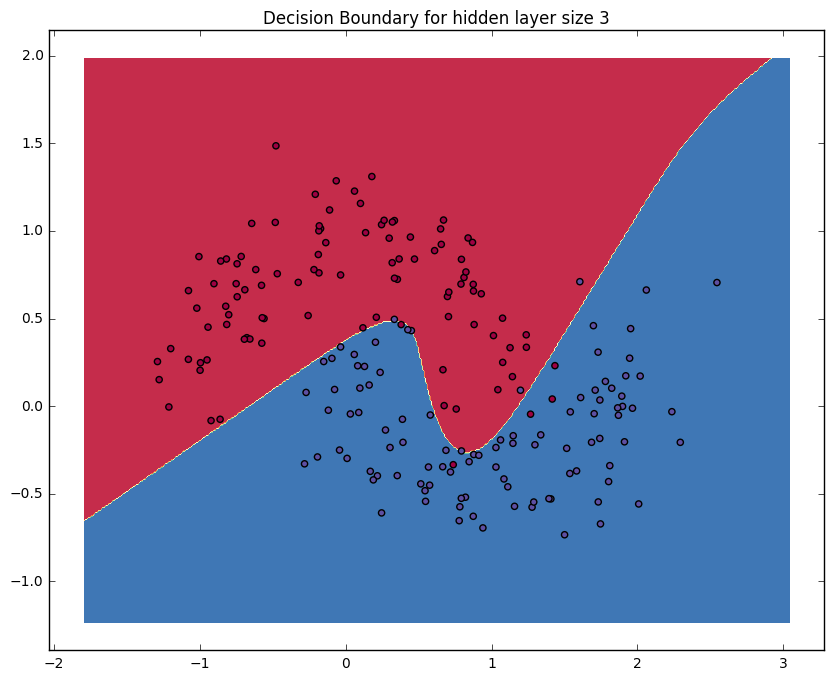

In [21]:
# Build a model with a 3-dimensional hidden layer
#Use our function to build a model with 3 hidden layers, trained in 6000 passes and print loss every 1000 steps
model = build_model(3, num_passes=6000, print_loss=True)

# Plot the decision boundary
plot_decision_boundary(lambda x: predict(model, x))
plt.title("Decision Boundary for hidden layer size 3")

Congratulation, you are done! You can check out more options and a more efficient version with GPU acceleration using Theano here: http://www.wildml.com/2015/09/speeding-up-your-neural-network-with-theano-and-the-gpu/ 

You can also consider to learn python adn Deep Learning using other examples from this blog: http://www.wildml.com/

The code was completely written by Denny Britz (https://github.com/dennybritz/nn-from-scratch/blob/master/nn-from-scratch.ipynb);

Comments and Python 3.5 compatibility was added by Kai Heinrich (kai.heinrich@tu-dresden.de)